In [1]:
import itertools
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
np.random.seed(0)

[2017-03-08 09:32:35,006] You have 'numpy' version 1.10.1 installed, but 'gym' requires at least 1.10.4. HINT: upgrade via 'pip install -U numpy'.


# Multi-step bootstrapping (n-step methods)

First we implement the simple random walk example. In this example, we have 7 states (from left to right): left terminal, A, B, C, D, E, and right terminal. We start in state C, and all rewards are 0, apart from when we go from E to the right terminal state. This is illustrated below:

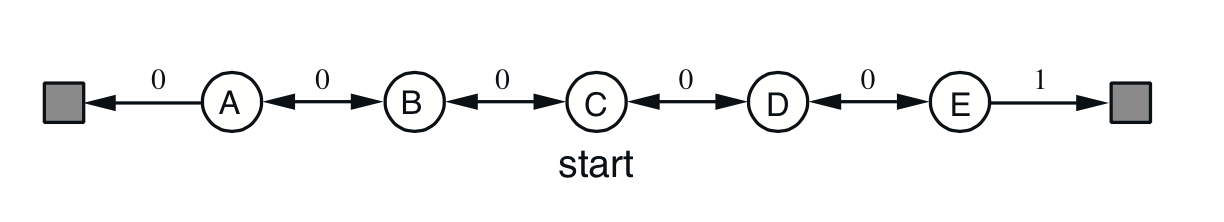

In [8]:
Image("./random_walk_game.png", width=600)

In [4]:
class RandomWalk(discrete.DiscreteEnv):
    metadata = {'render.modes':['human','ansi']}
    def __init__(self):
        self.shape = (7,)
        nS = np.prod(self.shape)
        nA = 2
        # calculate transition probabilities
        self.LEFT = 0
        self.RIGHT = 1
        P = {}
        for s in range(nS):
            P[s] = {a : [] for a in range(nA) }
            # observation, new_state, reward, is_done
            P[s][self.LEFT] = [(1.0, max(0, s-1), 0, True if max(0, s-1) == 0 else False)]
            P[s][self.RIGHT] = [(1.0, min(nS-1, s+1), 0, True if min(nS-1,s+1) == (nS-1) else False)]
        # the transition from E to RT is 1
        P[5][self.RIGHT] = [(1.0, 6, 1, True)]
        
        # we always start in state C (which is 3)
        isd = np.zeros(nS)
        isd[3] = 1.0
        
        super(RandomWalk, self).__init__(nS, nA, P, isd)
        
    def _step(self, a):
        transitions = self.P[self.s][a]
        p, s, r, d = transitions[0]
        self.s = s
        self.lastaction=a
        return (s, r, d, {"prob" : p})
    
    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        st = ['LT', 'A', 'B', 'C', 'D', 'E', 'RT']
        st[self.s] = '(' + st[self.s] + ')'
        outfile.write(" ".join(st))
        outfile.write("\n")

Test the game when we go all left

In [5]:
env = RandomWalk()
env.render()
print env.step(0)
env.render()
print env.step(0)
env.render()

LT A B (C) D E RT
(2, 0, False, {'prob': 1.0})
LT A (B) C D E RT
(1, 0, False, {'prob': 1.0})
LT (A) B C D E RT


Test the game when we go all right

In [6]:
env = RandomWalk()
env.render()
print env.step(1)
env.render()
print env.step(1)
env.render()
print env.step(1)

LT A B (C) D E RT
(4, 0, False, {'prob': 1.0})
LT A B C (D) E RT
(5, 0, False, {'prob': 1.0})
LT A B C D (E) RT
(6, 1, True, {'prob': 1.0})


-------

## n-step TD for estimating V

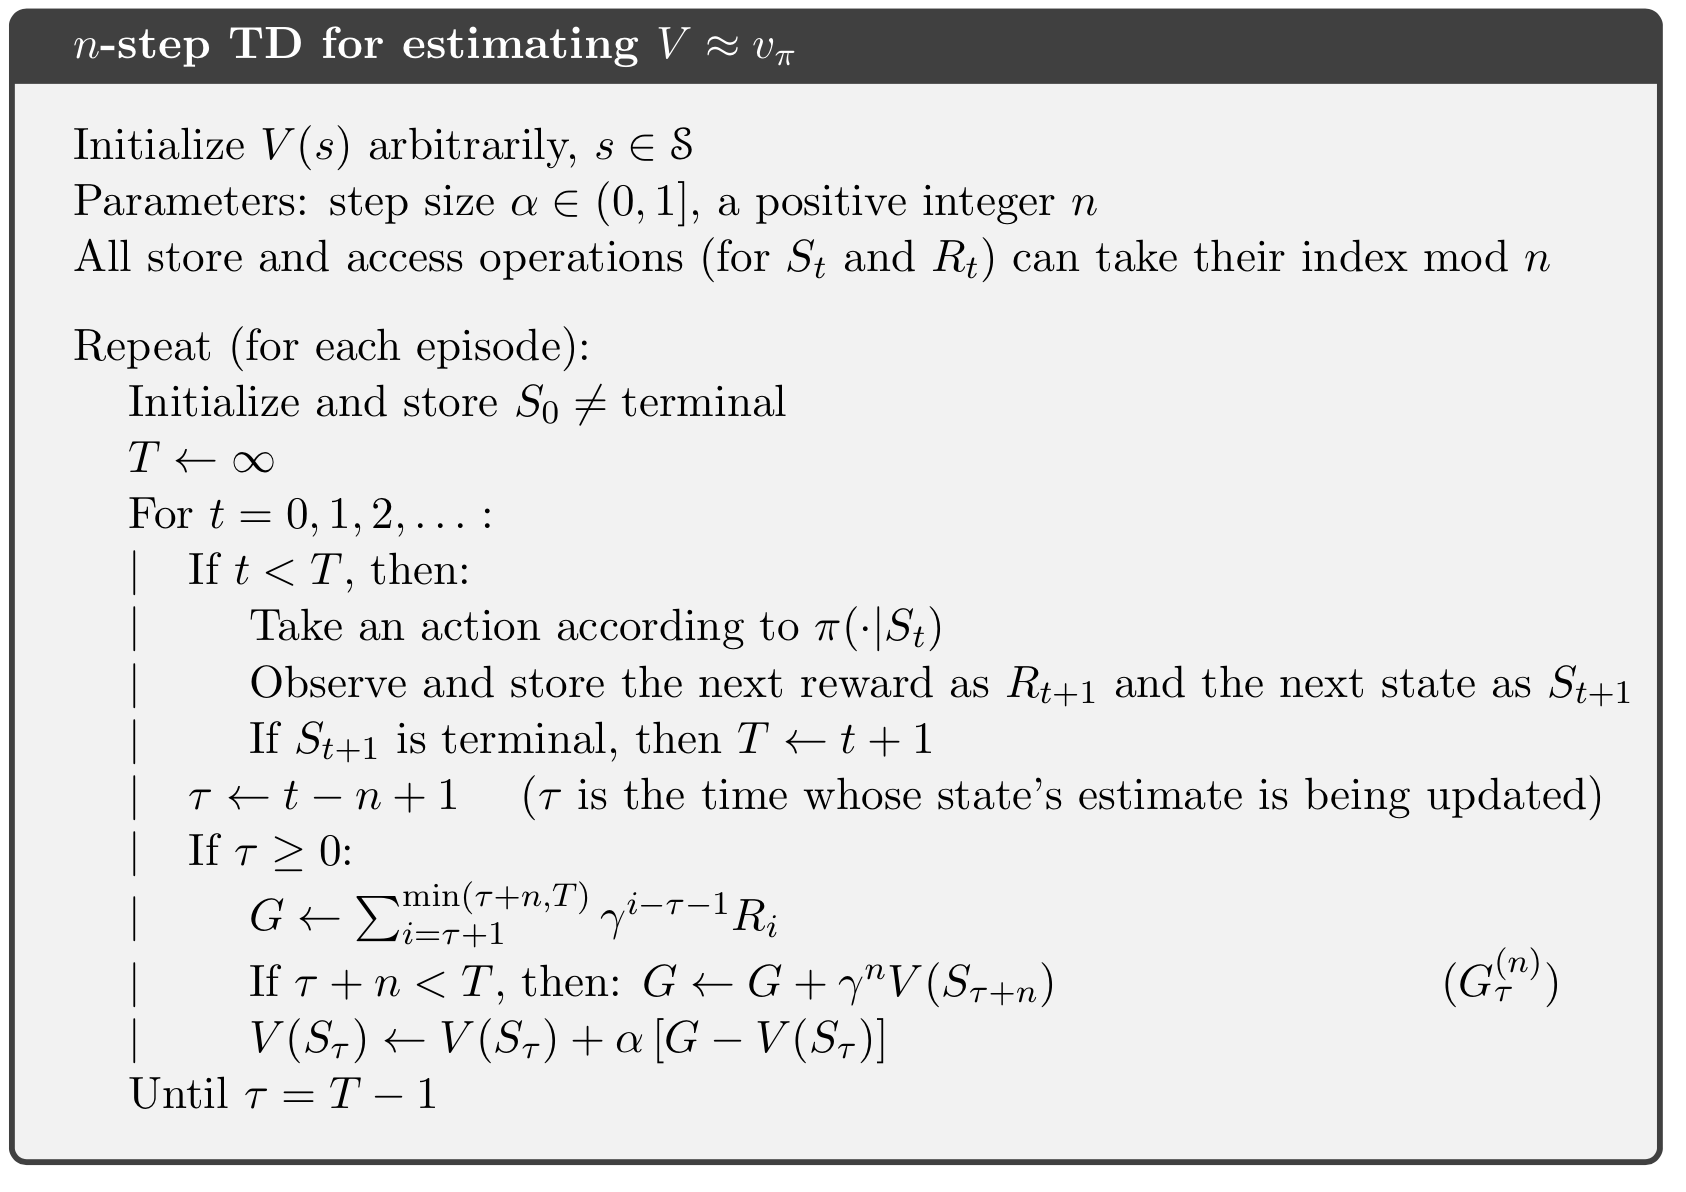

In [11]:
Image("./td_estimate_v.png", width=800)

We now present an implementation of this algorithm.

In [18]:
def n_step_td_estimate(env, policy, num_episodes, alpha, gamma, n, debug=False):
    # intialise V(s) arbitrarily
    V = np.zeros(env.nS)
    # repeat for each episode
    for num_episode in range(num_episodes):
        if debug:
            print "iter:", num_episode
        env.reset()
        T = np.inf
        rewards = dict() # TODO: not efficient
        states = dict()
        states[0] = env.s
        for t in itertools.count():
            #print t, states, V
            if t < T:
                # take an action according to the policy
                action = policy(env.s)
                _, R, is_done, _ = env.step(action)
                # observe and store the next reward as R_{t+1}, and the next state as S_{t+1}
                rewards[t+1] = R
                states[t+1] = env.s
                # if S_{t+1} is terminal, then T = t - 1
                if is_done:
                    T = t+1
            tau = t - n + 1
            #print tau
            if tau >= 0:
                if debug:
                    print "updating state %i," % states[tau],
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    G += ((gamma**(i-tau-1))*rewards[i])
                if tau + n < T:
                    G = G + (gamma**n)*V[ states[tau+n] ]
                if debug:
                    print "G = %i," % G,
                    print "V of state %i is %f" % (states[tau], V[states[tau]])
                V[ states[tau] ] += alpha*(G - V[ states[tau] ])
            if tau == T-1:
                break
    if debug:
        print
    return V

### Verifying the implementation

If we're following an always-right-walk policy, we expect that all states to the right of C receive a value of 1 (since whenever we are in these states, we will move right eventually hitting the terminal with a reward of 1)

In [19]:
def right_walk_policy(state):
    LEFT, RIGHT = 0, 1
    return RIGHT

In [121]:
n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=100, alpha=0.5, gamma=1, n=2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


array([ 0.,  0.,  0.,  1.,  1.,  1.,  0.])

Conversely, if we always go left, we expect to get an expected return of 0, always.

In [20]:
def left_walk_policy(state):
    LEFT, RIGHT = 0, 1
    return LEFT

In [138]:
n_step_td_estimate(env=RandomWalk(), policy=left_walk_policy, num_iters=100, alpha=0.5, gamma=1, n=2)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

Let us try a random walk policy with $n=2$ and $n=1$:

In [21]:
def random_policy(state):
    LEFT, RIGHT = 0, 1
    if np.random.randint(0,2) == 0:
        return LEFT
    else:
        return RIGHT

For $n = 2$:

In [174]:
np.random.seed(0)
V = n_step_td_estimate(env=RandomWalk(), policy=random_policy, num_iters=10000, alpha=0.01, gamma=1, n=2)
print V[ [1,2,3,4,5] ]

[ 0.18261455  0.34008082  0.49672043  0.66335435  0.83086432]


From the textbook, the real values are (1/6, 2/6, 3/6, 4/6, and 5/6) for A, B, C, D, and E, respectively, so let's check that:

In [175]:
print [1.0/6, 2.0/6, 3.0/6, 4.0/6, 5.0/6]

[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]


For $n = 1$:

In [176]:
np.random.seed(0)
V = n_step_td_estimate(env=RandomWalk(), policy=random_policy, num_iters=10000, alpha=0.01, gamma=1, n=1)
print V[ [1,2,3,4,5] ]

[ 0.17417513  0.33827588  0.49017577  0.66800682  0.83955003]


So far it looks like things are correct!

From the textbook, "a one-step method would change only the estimate for the last state, $V(E)$, which would be incremented toward 1, the observed return". This is because we go from C to D (immediate reward = 0), from D to E ( immediate reward = 0), and E to terminal (immediate reward = 1), so E only gets updated.

In [201]:
V = n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=1, alpha=0.01, gamma=1, n=1, debug=True)
print V

iter: 0
updating state 3, G = 0, V of state 3 is 0.000000
updating state 4, G = 0, V of state 4 is 0.000000
updating state 5, G = 1, V of state 5 is 0.000000

[ 0.    0.    0.    0.    0.    0.01  0.  ]


...where state 3 = 'C', state 4 = 'D', and state 5 = 'E'. We can see that only the state E got updated, with a value of 0.01.

From the textbook, "a two step method, on the other hand, would increment the values of the two states preceding termination: $V(D)$ and $V(E)$". This is because the immediate reward from D to the terminal state is 1, and also because the immediate reward from E to the terminal state is 1

In [206]:
V = n_step_td_estimate(env=RandomWalk(), policy=right_walk_policy, num_iters=1, alpha=0.01, gamma=1, n=2, debug=True)
print V

iter: 0
updating state 3, G = 0, V of state 3 is 0.000000
updating state 4, G = 1, V of state 4 is 0.000000
updating state 5, G = 1, V of state 5 is 0.000000

[ 0.    0.    0.    0.    0.01  0.01  0.  ]


We can see that $V(D)$ and $V(E)$ got updated this time.

-------

## Some discussion and experiments

We can see that there is a trade-off to be made for $n$: in the extreme case, we perform Monte-Carlo updates, and then we perform updates on the state values extremely late (i.e. after we have hit the terminal state). In the other extreme case ($n=1$), we perform updates after single steps, which doesn't seem all that ideal, since we are computing updates based on very little information (in this case, simply the immedate reward, $R_{t+1}$), and the estimated value for $S_{t+1}$.

It doesn't seem clear however which value of $n$ we should pick. Figure 7.4 in Sutton's book makes an interesting point about the effect of $n$: the one-step method 'strengthens only the last action of the sequence of actions that led to the high reward, whereas the $n$-step method strengths the last $n$ actions in the sequence, so that much more is learned from the one episode'. Judging from this statement, it seems like we wouldn't want to make $n$ too big, because then we could end up unnecessarily strengthening actions that are so far away in the past and had little to do with the reward we have received in the present moment??

Just like in the chapter, we now implement an extreme version of the random walk, so that we can examine the effect of $n$ on the estimation of the value function. In this one, we have 19 states, we start in the middle just like before, but this time we only get a reward of 1 if we go from the left-most state to the left-most terminal state -- all other rewards are 0.

In [22]:
class ExtremeRandomWalk(discrete.DiscreteEnv):
    metadata = {'render.modes':['human','ansi']}
    def __init__(self):
        num_states = 19
        self.shape = (num_states,)
        nS = np.prod(self.shape)
        nA = 2
        # calculate transition probabilities
        self.LEFT = 0
        self.RIGHT = 1
        P = {}
        for s in range(nS):
            P[s] = {a : [] for a in range(nA) }
            # observation, new_state, reward, is_done
            P[s][self.LEFT] = [(1.0, max(0, s-1), 0, True if max(0, s-1) == 0 else False)]
            P[s][self.RIGHT] = [(1.0, min(nS-1, s+1), 0, True if min(nS-1,s+1) == (nS-1) else False)]
        # the transition from the left-most state to the left terminal is a reward of 1
        P[1][self.LEFT] = [(1.0, 0, 1, True)]
        
        # we always start in state C (which is 3)
        isd = np.zeros(nS)
        isd[9] = 1.0
        
        super(ExtremeRandomWalk, self).__init__(nS, nA, P, isd)
        
    def _step(self, a):
        transitions = self.P[self.s][a]
        p, s, r, d = transitions[0]
        self.s = s
        self.lastaction=a
        return (s, r, d, {"prob" : p})
    
    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        st = [ str(x) for x in range(self.nS) ]
        st[self.s] = '(' + st[self.s] + ')'
        outfile.write(" ".join(st))
        outfile.write("\n")

Let's calculate the real values for the value function:

In [23]:
tmp=ExtremeRandomWalk()
real_vals = []
for i in range(1, tmp.nS-2+1):
    real_vals.append( (i*1.0) / (tmp.nS-1) )
real_vals = [0] + real_vals[::-1] + [0]
real_vals = np.asarray(real_vals)
print real_vals

[ 0.          0.94444444  0.88888889  0.83333333  0.77777778  0.72222222
  0.66666667  0.61111111  0.55555556  0.5         0.44444444  0.38888889
  0.33333333  0.27777778  0.22222222  0.16666667  0.11111111  0.05555556
  0.        ]


Ok, now let's run an experiment. We're going to let $n$ range from 1 to $|S|$ (the number of states). For each $n$, we're going to do 100 repeats of the $n$ step value estimation algorithm (implemented above), average all the value functions, and then calculate the MSE between that and the real value function (calculated above). We only try one hyperparameter setting of the algorithm, which is a discount factor $\gamma = 1$ and learning rate $\alpha = 0.01$

In [25]:
mses = []
for n in range(1, tmp.nS):
    V = np.zeros(tmp.nS)
    num_repeats = 100
    for repeat in range(num_repeats):
        V += n_step_td_estimate(env=ExtremeRandomWalk(), policy=random_policy, num_episodes=10, alpha=0.01, gamma=1, n=n, debug=False)
    V = np.sum(V, axis=0) / num_repeats
    mse = np.mean((V - real_vals)**2)
    print n, mse
    mses.append(mse)

1 0.246138697856
2 0.212300426768
3 0.173752228219
4 0.145053402385
5 0.129691901403
6 0.105316205004
7 0.103421262023
8 0.0927210615262
9 0.0901299950032
10 0.0920830076229
11 0.101960467167
12 0.115891469435
13 0.123747947354
14 0.157460510215
15 0.150911080302
16 0.195474836519
17 0.247648362603
18 0.252742063625


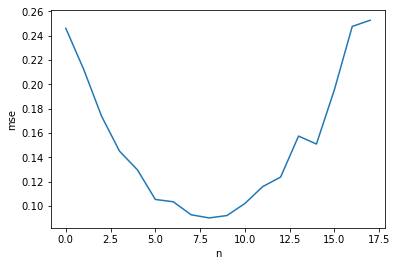

In [26]:
plt.plot(mses)
plt.xlabel("n")
plt.ylabel("mse")

We can see that $n = 9$ is the optimal value for this experiment.

----

## n-step SARSA for estimating Q

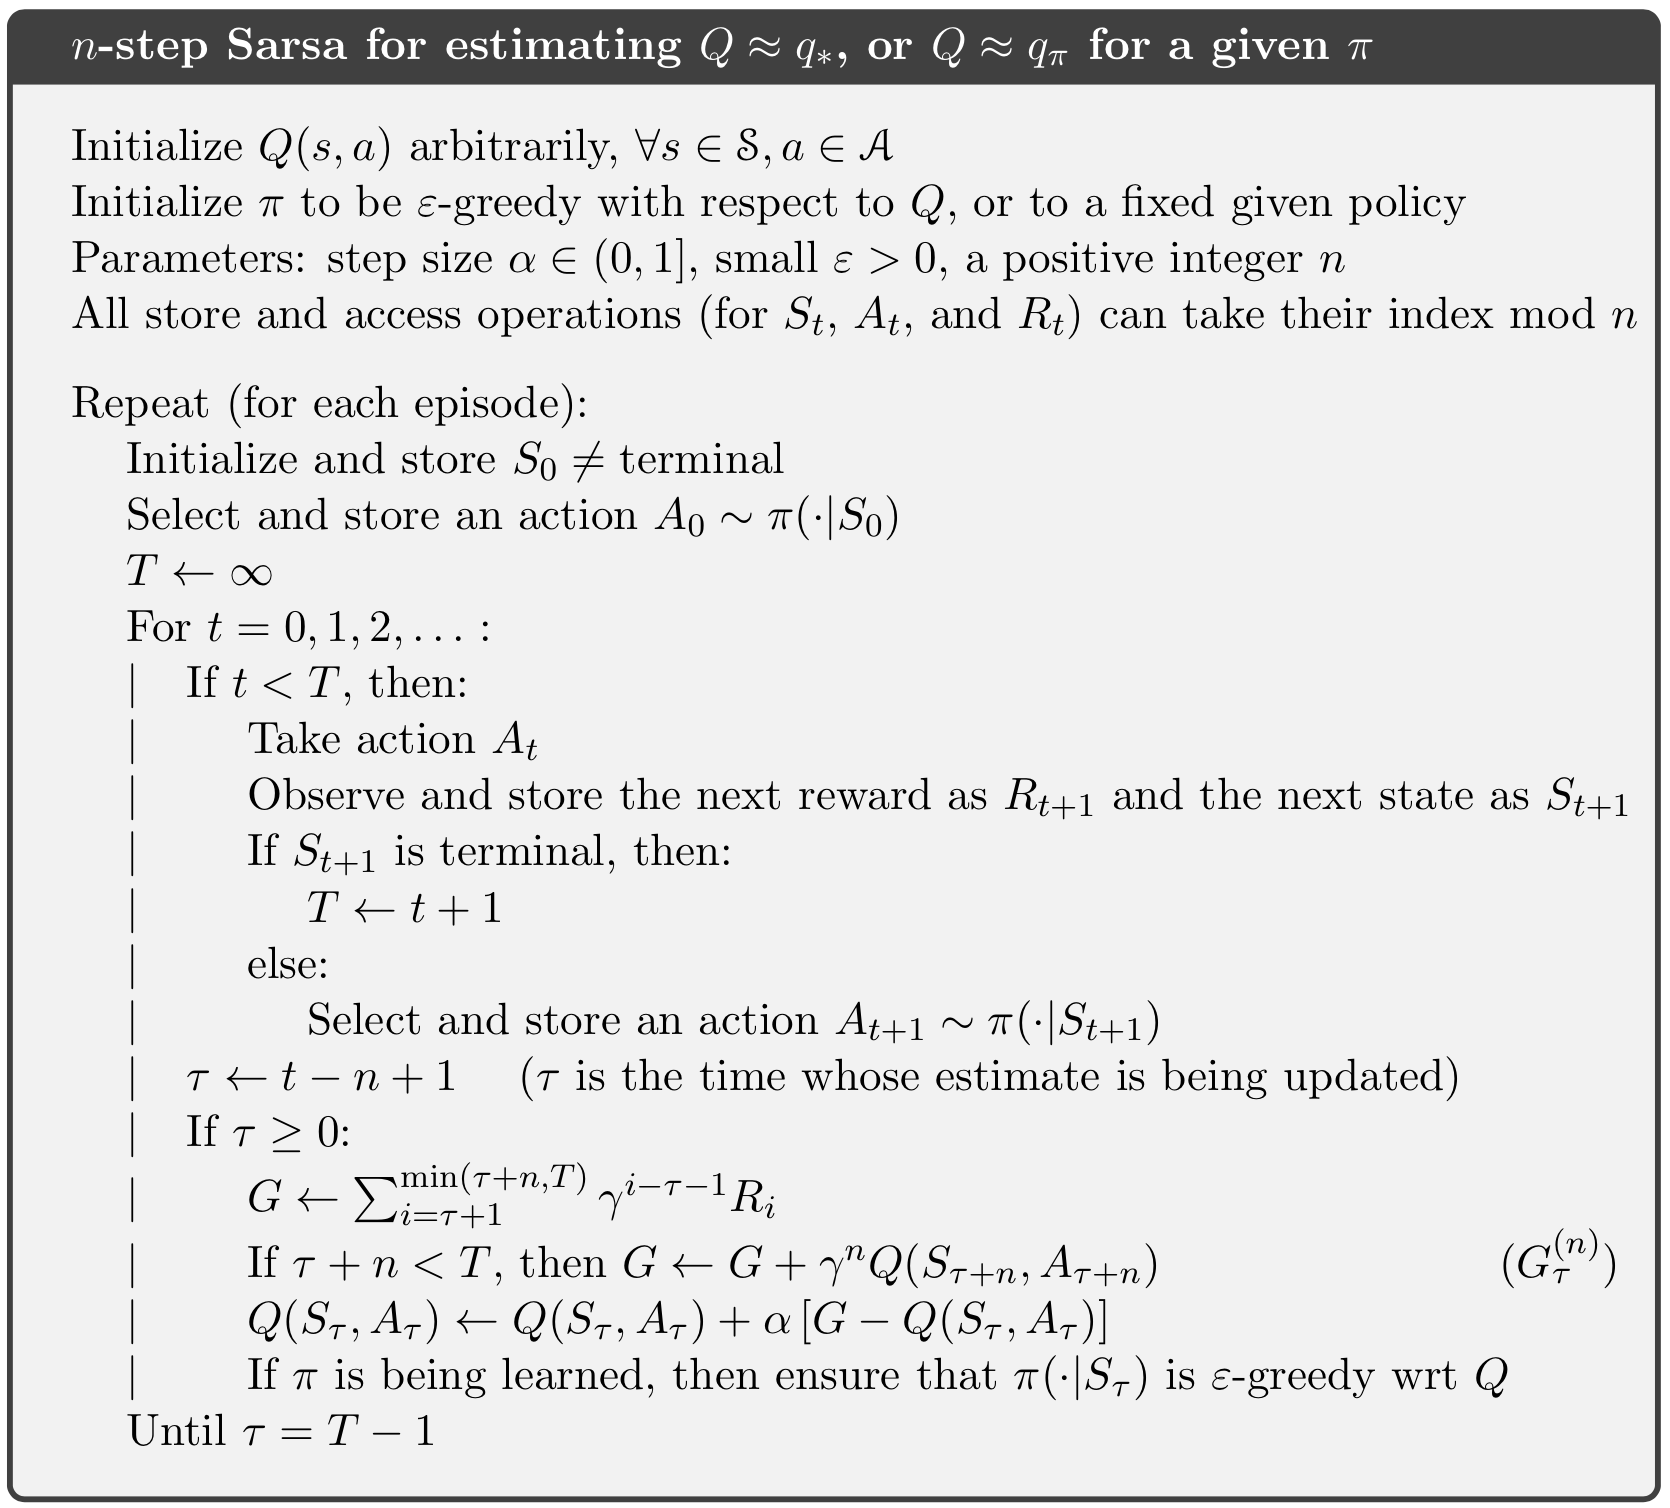

In [27]:
Image("./n_step_sarsa.png", width=800)

In [40]:
def Q_to_eps_greedy_policy(Q, eps=0.1):
    num_actions = Q.shape[1]
    pi = np.zeros(Q.shape[0],)
    for i in range(0, Q.shape[0]):
        if np.random.uniform(0,1) < eps:
            # choose a random action
            pi[i] = np.random.randint(0, num_actions)
        else:
            # take the argmax of Q[s,.]
            pi[i] = np.argmax(Q[i])
    return pi

In [92]:
def n_step_sarsa(env, num_episodes, epsilon, alpha, gamma, n, debug=False):
    # intialise Q(s, a) arbitrarily
    Q = np.zeros((env.nS, env.nA))
    # initialise pi to be eps-greedy wrt Q, or to a fixed given policy
    pi = Q_to_eps_greedy_policy(Q, epsilon)
    if debug:
        print pi
    # repeat for each episode
    eps_lengths = []
    for num_episode in range(num_episodes):
        if debug:
            print "iter:", num_episode
        env.reset()
        T = np.inf
        rewards = dict() # TODO: not efficient
        # initialise and store S_0 != terminal
        states = dict()
        states[0] = env.s
        # select and store an action A_0 ~ pi
        actions = dict()
        actions[0] = pi[ states[0] ]
        eps_length = 0
        for t in itertools.count():
            if t < T:
                # take an action A_t
                action = actions[t]
                # observe and store the next reward as R_{t+1}, and the next state as S_{t+1}
                _, R, is_done, _ = env.step(int(action))
                rewards[t+1] = R
                states[t+1] = env.s
                # if S_{t+1} is terminal, then T = t - 1
                if is_done:
                    T = t+1
                else:
                    # select and store an action A_{t+1} ~ pi
                    actions[t+1] = pi[ states[t+1] ]
                    eps_length += 1
            tau = t - n + 1
            #print tau
            if tau >= 0:
                if debug:
                    print "updating state %i," % states[tau],
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    G += ((gamma**(i-tau-1))*rewards[i])
                if tau + n < T:
                    G = G + (gamma**n)*Q[ states[tau+n], actions[tau+n] ]
                if debug:
                    print "G = %i," % G,
                    print "Q of state/action %i/%i is %f" % (states[tau], actions[tau], Q[states[tau],actions[tau]])
                Q[ states[tau], actions[tau] ] += alpha*(G - Q[ states[tau], actions[tau] ])
                # if pi is being learned, then sure that pi is eps-greedy wrt Q
                pi = Q_to_eps_greedy_policy(Q, epsilon)
            if tau == T-1:
                break
        eps_lengths.append(eps_length)
    if debug:
        print
    return Q, eps_lengths

Let's try the random walk example.

In [67]:
Q, _ = n_step_sarsa(env=RandomWalk(), num_episodes=10000, epsilon=0.1, alpha=0.01, gamma=1, n=2)
print "Q:", Q
print "pi:", Q_to_eps_greedy_policy(Q, eps=0)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Q: [[ 0.          0.        ]
 [ 0.          0.12899777]
 [ 0.11091334  0.91684424]
 [ 0.86305574  0.99886669]
 [ 0.98686782  0.99999886]
 [ 0.97822519  1.        ]
 [ 0.          0.        ]]
pi: [ 0.  1.  1.  1.  1.  1.  0.]


It seems to work... the best action to take at any state is the right action, since this gives the best reward.

Let's also try this for GridWorld. The OpenAI Gym environment for this example is courtesy of Denny Britz: https://raw.githubusercontent.com/dennybritz/reinforcement-learning/master/lib/envs/gridworld.py

In [93]:
import gridworld

In [94]:
env = gridworld.GridworldEnv(shape=[10,10])

In [95]:
env.render()

T  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  T


In [96]:
Q, _ = n_step_sarsa(env=env, num_episodes=10000, epsilon=0.1, alpha=0.01, gamma=1, n=2)

/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [97]:
env.render()

T  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x


Let's plot the best action to take on each cell of the grid.

In [98]:
best_actions = []
adt = {0:"up", 1:"rt", 2:"dn", 3:"lf"}
for row in Q:
    best_actions.append(adt[np.argmax(row)])
best_actions = np.asarray(best_actions)
best_actions = best_actions.reshape((10,10))
best_actions[0,0] = "--"
best_actions[9,9] = "--"
best_actions

array([['--', 'lf', 'lf', 'lf', 'lf', 'lf', 'lf', 'lf', 'lf', 'lf'],
       ['up', 'up', 'lf', 'up', 'lf', 'lf', 'lf', 'lf', 'rt', 'dn'],
       ['up', 'up', 'up', 'up', 'up', 'lf', 'lf', 'up', 'dn', 'dn'],
       ['up', 'lf', 'up', 'lf', 'up', 'lf', 'lf', 'dn', 'rt', 'dn'],
       ['up', 'up', 'lf', 'up', 'up', 'lf', 'lf', 'dn', 'rt', 'dn'],
       ['up', 'up', 'lf', 'lf', 'lf', 'rt', 'rt', 'rt', 'rt', 'dn'],
       ['up', 'up', 'lf', 'rt', 'dn', 'rt', 'dn', 'dn', 'rt', 'dn'],
       ['up', 'up', 'up', 'dn', 'lf', 'up', 'rt', 'dn', 'rt', 'dn'],
       ['up', 'rt', 'rt', 'dn', 'dn', 'dn', 'rt', 'dn', 'rt', 'dn'],
       ['rt', 'rt', 'rt', 'rt', 'rt', 'rt', 'rt', 'rt', 'rt', '--']], 
      dtype='|S2')

In [102]:
This looks reasonable.

SyntaxError: invalid syntax (<ipython-input-102-b54a8fc2a5b5>, line 1)

### Let's plot episode lengths for different values of n

Run Gridworld for $n \in \{1, \dots, n\}$, and for each $n$, do 5 replicates and average the episode lengths.

In [116]:
results = {}
num_replicates = 5
for n in range(1, 10):
    print "running experiment for n = %i" % n
    eps_lengths = None
    for replicate in range(num_replicates):
        env = gridworld.GridworldEnv(shape=[10,10])
        _, this_eps_lengths = n_step_sarsa(env=env, num_episodes=3000, epsilon=0.1, alpha=0.01, gamma=1, n=n)
        this_eps_lengths = np.asarray(this_eps_lengths)
        if eps_lengths == None:
            eps_lengths = this_eps_lengths
        else:
            eps_lengths += this_eps_lengths
    eps_lengths = eps_lengths / num_replicates
    results[n] = eps_lengths

running experiment for n = 1


/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


running experiment for n = 2
running experiment for n = 3
running experiment for n = 4
running experiment for n = 5
running experiment for n = 6
running experiment for n = 7
running experiment for n = 8
running experiment for n = 9


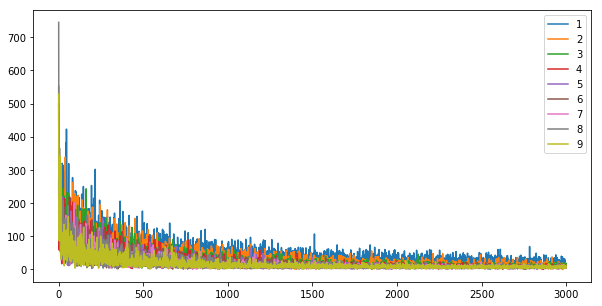

In [126]:
plt.figure(figsize=(10,5))
for key in results:
    plt.plot(results[key])
plt.legend(results.keys())
plt.show()